# IWT2- abs(H)

In [83]:
%cd /Users/user/Desktop/IWF-DNN/data2DComplex
%pwd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function
import scipy.io as sio
import time
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/user/Desktop/IWF-DNN/data2DComplex


In [35]:
np.abs(Ydata[1:3,:])

array([[0.3410883 , 1.21694904, 1.21694904, 4.34188149, 0.        ,
        0.        , 0.        , 0.        , 4.83346841, 1.52881677,
        1.52881677, 0.4835618 ],
       [0.        , 0.        , 0.        , 0.        , 3.91945366,
        2.03702534, 2.03702534, 1.05868639, 1.04150736, 2.03606643,
        2.03606643, 3.98035259]])

In [93]:
DateLocation='MIMO50000_3.mat'
Data = sio.loadmat(DateLocation)#load data
Xdata=np.abs(Data['X'])
Ydata=np.abs(Data['Y'])
# Xdata=np.abs(Xdata)
# trainData = np.reshape(XXData,[12 ,50000 ])#reshape to 2d array
Xdata = np.transpose(Xdata)
Ydata = np.transpose(Ydata)
x_train, x_val ,y_train, y_val= train_test_split(Xdata, Ydata, test_size=0.3)

In [96]:
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import MLPClassifier,MLPRegressor
abs_NN=MLPRegressor(activation='relu', learning_rate_init=0.001 ,solver='sgd',max_iter=100
                    ,alpha=1e-5,hidden_layer_sizes=(200,80,80), random_state=1)
abs_NN.fit(x_train, y_train)

/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 80, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [97]:
import time
def test(X, model_location, save_name, n_input, n_output, n_hidden_1 = 200, n_hidden_2 = 80, n_hidden_3 = 80, n_hidden_4 = 40,binary=0):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_input])
    is_train = tf.placeholder("bool")
    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights4(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, n_output)
    pred = multilayer_perceptron4(x, weights, biases, input_keep_prob, hidden_keep_prob)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_location)
        start_time = time.time()
        y_pred = sess.run(pred, feed_dict={x: X, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        testtime = time.time() - start_time
        # print("testing time: %0.2f s" % testtime)
        if binary==1:
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
        sio.savemat(save_name, {'pred': y_pred})
    return y_pred

def DABtoComplex(XX, dim):
    size=XX.shape[1]
    X=np.empty( (XX.shape[0], dim), dtype= np.complex128 )
    X.real[:,:]=XX[:,0:dim]
    X.imag[:,:]=XX[:,dim:2*dim]
    return X
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[M,N,K])
        pnn=np.reshape(y_pred[i,:],[M,N,K])      
        for j in range(K):
            if j==i:
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[:,:,j] * pnn[:,:,j] * np.transpose(H[:,:,j]))))
            else:
                pnn[:,:,j]=pnn[:,:,j]+pnn[:,:,j-1]
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[:,:,j] * pnn[:,:,j] * np.transpose(H[:,:,j]))/np.linalg.det((np.eye(M)+H[:,:,j] * pnn[:,:,j-1] * np.transpose(H[:,:,j])))))
        sum_rate.append(rate_nn)
    return sum_rate

def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))
    
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0

def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 5])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.show()
    return 0
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0

def testPerformance(model_location, save_name, n_input, n_output,dim, M, N, K,samples):
    ypred=test(Xtest, model_location, save_name+'%s'%('test'), n_input,n_output, binary=0)
    trainPred=test(x_train, model_location, save_name+"%s"%('train'), n_input,n_output, binary=0)
    valPred=test(x_val, model_location, save_name+"%s"%('val'), n_input,n_output, binary=0)
    x=DABtoComplex(X,dim)
    xtest=DABtoComplex(Xtest,dim)
    ytest=DABtoComplex(Ytest,dim)
    ypred=DABtoComplex(ypred,dim)

    # train & val
    xtrain=DABtoComplex(x_train,dim)
    ytrain=DABtoComplex(y_train,dim)
    trainPred=DABtoComplex(trainPred,dim)
    xval=DABtoComplex(x_val,dim)
    yval=DABtoComplex(y_val,dim)
    valPred=DABtoComplex(valPred,dim)

    # test
    nnsumRate=obj_sum_rate(xtest, ypred, M, N, K, samples)
    IWFsumRate=obj_sum_rate(xtest, ytest, M, N, K, samples)
    #trian
    nnSRTrain=obj_sum_rate(xtrain, trainPred, M, N, K, samples)
    IWFSRTrain=obj_sum_rate(xtrain, ytrain, M, N, K, samples)
    # validation
    IWFSRVal=obj_sum_rate(xval, yval, M, N, K, samples)
    nnSRVal=obj_sum_rate(xval, valPred, M, N, K, samples)

    plt.figure(1)
    plt.subplot(311)
    plt.title('CDF AnalysisTest')
    CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
    plt.subplot(312)
    plt.title('CDF Analysis_Train')
    CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
    plt.subplot(313)
    plt.title('CDF Analysis_val')
    CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')
    
    plt.figure(2)
    plt.subplot(211)
    plt.title('Hist AnalysisTest')
    histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
    plt.subplot(212)
    plt.title('Hist Analysis_Train')
    histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
    
    performance(IWFsumRate, nnsumRate, samples)
    performance(IWFSRTrain, nnSRTrain, samples)
    return 0
    

/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log2
/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log2


10000
10000


ValueError: range parameter must be finite.

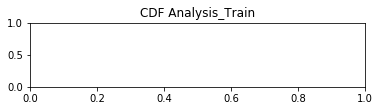

In [100]:
# NN_y_train_pre_proba=T6_NN.predict_proba(T6_X_train)
# DateLocation='MIMO10000_3test.mat'
# DataTest10000 = sio.loadmat(DateLocation)#load data
# Xtest=DataTest10000['X']
# Xtest = np.transpose(Xtest)
# Ytest=DataTest10000['Y']
# Ytest = np.transpose(Ytest)
# Xtest = np.column_stack((np.real(Xtest), np.imag(Xtest)))
# Ytest = np.column_stack((np.real(Ytest), np.imag(Ytest)))

# Xtest -= mean
# Xtest /= std

trainPred=abs_NN.predict(x_train)

# NN_y_test_pre_proba=T6_NN.predict_proba(T6_X_test)
valPred=abs_NN.predict(x_val)
# ypred=NN.predict(Xtest)
D=12
# x=DABtoComplex(X,12)
# xtest=DABtoComplex(Xtest,12)
# ytest=DABtoComplex(Ytest,12)
# ypred=DABtoComplex(ypred,12)

# train & val
# xtrain=DABtoComplex(x_train,12)
# ytrain=DABtoComplex(y_train,12)
# trainPred=DABtoComplex(trainPred,12)
# xval=DABtoComplex(x_val,12)
# yval=DABtoComplex(y_val,12)
# valPred=DABtoComplex(valPred,12)
xtrain=x_train
ytrain=y_train
xval=x_val
yval=y_val
# # test
# nnsumRate=obj_sum_rate(xtest, ypred,2,2,3, 10000)
# IWFsumRate=obj_sum_rate(xtest, ytest,2,2,3, 10000)
#trian
nnSRTrain=obj_sum_rate(xtrain, trainPred,2,2,3, 10000)
IWFSRTrain=obj_sum_rate(xtrain, ytrain,2,2,3, 10000)
# validation
IWFSRVal=obj_sum_rate(xval, yval,2,2,3, 10000)
nnSRVal=obj_sum_rate(xval, valPred,2,2,3, 10000)

print(len(nnsumRate))
print(len(IWFsumRate))
plt.figure(1)
# plt.subplot(311)
# plt.title('CDF AnalysisTest')
# CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')
plt.subplot(313)
plt.title('CDF Analysis_Val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNTrain', 'IWFTrain')

plt.figure(2)
# plt.subplot(311)
# plt.title('Hist AnalysisTest')
# histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(312)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])
plt.subplot(313)
plt.title('Hist Analysis_val')
histPlot(nnSRVal,IWFSRVal, ['DNNTrain', 'IWFTrain'])
print('test:')
performance(IWFsumRate, nnsumRate, 10000)
print('Train:')
performance(IWFSRTrain, nnSRTrain, 10000)
print('Val:')
performance(IWFSRVal, nnSRVal, 10000)

In [94]:
# Functions for deep neural network weights initialization
def ini_weights(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_output):
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1]) / np.sqrt(n_input)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2]) / np.sqrt(n_hidden_1)),
        'h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3]) / np.sqrt(n_hidden_2)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_3, n_output])) / n_hidden_3,
    }
    biases = {
        'b1': tf.Variable(tf.ones([n_hidden_1]) * 0.1),
        'b2': tf.Variable(tf.ones([n_hidden_2]) * 0.1),
        'b3': tf.Variable(tf.ones([n_hidden_3]) * 0.1),
        'out': tf.Variable(tf.ones([n_output]) * 0.1),
    }
    return weights, biases

# Functions for deep neural network structure construction
def multilayer_perceptron(x, weights, biases,input_keep_prob,hidden_keep_prob):
#     x = tf.nn.dropout(x, input_keep_prob)                         # dropout layer
    
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])   # x = wx+b
    layer_1 = tf.nn.relu(layer_1)                                 # x = max(0, x)
#     layer_1 = tf.nn.dropout(layer_1, hidden_keep_prob)            # dropout layer

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
#     layer_2 = tf.nn.dropout(layer_2, hidden_keep_prob)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
#     layer_3 = tf.nn.dropout(layer_3, hidden_keep_prob)

    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
#     out_layer = tf.nn.relu6(out_layer) / 6
    return out_layer

In [95]:
def train(X_train, X_val, Y_train, Y_val ,location, training_epochs=300, batch_size=1000, LR= 0.001, n_hidden_1 = 200,n_hidden_2 = 80,n_hidden_3 = 80, traintestsplit = 0.01, LRdecay=0):
    num_total = X_train.shape[0] +X_val.shape[0]                       # number of total samples
    num_val =X_val.shape[0]# number of validation samples
    num_train = X_train.shape[0] # number of training samples
    n_input = X_train.shape[1]                          # input size
    n_output = Y_train.shape[1]                         # output size
#     X_train = np.transpose(X[:, 0:num_train])     # training data
#     Y_train = np.transpose(Y[:, 0:num_train])     # training label
#     X_val = np.transpose(X[:, num_train:num_total]) # validation data
#     Y_val = np.transpose(Y[:, num_train:num_total]) # validation label

    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("float", [None, n_output])
    is_train = tf.placeholder("bool")
    learning_rate = tf.placeholder(tf.float32, shape=[])
    total_batch = int(num_total / batch_size)
    print('train: %d ' % num_train, 'validation: %d ' % num_val)

    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_output)
    pred = multilayer_perceptron(x, weights, biases, input_keep_prob, hidden_keep_prob)
    cost = tf.reduce_mean(tf.square(pred - y))    # cost function: MSE
    optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
#     optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost) # training algorithms: RMSprop
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    MSETime=np.zeros((training_epochs,3))
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time()
        for epoch in range(training_epochs):
            for i in range(total_batch):
                idx = np.random.randint(num_train,size=batch_size)
                if LRdecay==1:
                    _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                  input_keep_prob: 1, hidden_keep_prob: 1,
                                                                  learning_rate: LR/(epoch+1), is_train: True})
                elif LRdecay==0:
                    _, c = sess.run([optimizer, cost], feed_dict={x: X_train[idx, :], y: Y_train[idx, :],
                                                                      input_keep_prob: 1, hidden_keep_prob: 1,
                                                                      learning_rate: LR, is_train: True})
            MSETime[epoch, 0]= c # train cost 
            MSETime[epoch, 1]= sess.run(cost, feed_dict={x: X_val, y: Y_val, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
            MSETime[epoch, 2]= time.time() - start_time
            if epoch%(int(training_epochs/10))==0:
                print('epoch:%d, '%epoch, 'train:%0.2f%%, '%(c*100), 'validation:%0.2f%%.'%(MSETime[epoch, 1]*100))

        print("training time: %0.2f s" % (time.time() - start_time))
        sio.savemat('./DNNabs2MSETime_%d_%d_%d' % (n_output, batch_size, LR*10000) , {'train': MSETime[:,0], 'validation': MSETime[:,1], 'time': MSETime[:,2]})
        saver.save(sess, location)
    return 0

In [67]:
# 3 layers (output layer without relu) , no dropout layers ADMA optimizer LR: 0.001
model_location = "./DNNabs/model_demo.ckpt"
train(x_train,x_val, y_train,y_val, model_location, training_epochs=200,LR=0.001, batch_size=200)

train: 35000  validation: 15000 
epoch:0,  train:116.68%,  validation:109.04%.
epoch:20,  train:72.97%,  validation:69.19%.
epoch:40,  train:64.53%,  validation:68.50%.
epoch:60,  train:70.80%,  validation:66.79%.
epoch:80,  train:58.67%,  validation:66.93%.
epoch:100,  train:58.32%,  validation:66.68%.
epoch:120,  train:56.08%,  validation:67.13%.
epoch:140,  train:52.50%,  validation:67.35%.
epoch:160,  train:56.37%,  validation:68.11%.
epoch:180,  train:56.55%,  validation:68.07%.
training time: 163.00 s


0

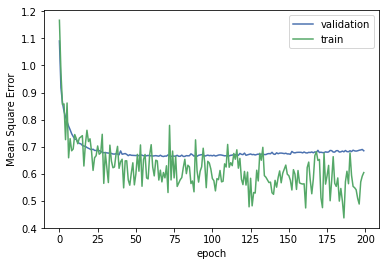

In [68]:
train = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['train']
time = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['time']
val = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['validation']
plt.figure(0)
plt.plot(np.arange(0,len(val.T)), val.T,label='validation')
plt.plot(np.arange(0,len(train.T)), train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

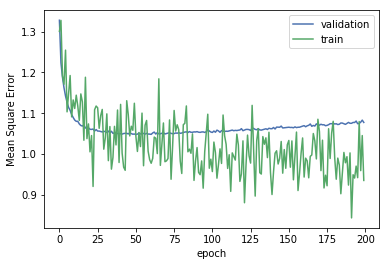

In [42]:
train = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['train']
time = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['time']
val = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['validation']
plt.figure(0)
plt.plot(np.arange(0,len(val.T)), val.T,label='validation')
plt.plot(np.arange(0,len(train.T)), train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

In [92]:
train = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['train']
time = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['time']
val = sio.loadmat('MSETimeLastLayer_%d_%d_%d'%(12, 200, 10))['validation']
plt.figure(0)
plt.plot(np.arange(0,len(val.T)), val.T,label='validation')
plt.plot(np.arange(0,len(train.T)), train.T,label='train')
plt.legend(loc='upper right')
plt.xlabel('time (seconds)')
plt.ylabel('Mean Square Error')
plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'MSETimeLastLayer_12_200_10.mat'

# Test Performance

In [69]:
DateLocation='MIMO10000_3test.mat'
DataTest1000 = sio.loadmat(DateLocation)#load data
Xtest=DataTest1000['X']
# trainData = np.reshape(XXData,[12 ,50000 ])#reshape to 2d array
Xtest = np.transpose(Xtest)
Ytest=DataTest1000['Y']
# trainData = np.reshape(XXData,[12 ,50000 ])#reshape to 2d array
Ytest = np.transpose(Ytest)

In [70]:

# Functions for deep neural network testing
def test(X, model_location, save_name, n_input, n_output, n_hidden_1 = 200, n_hidden_2 = 80, n_hidden_3 = 80, binary=0):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_input])
    is_train = tf.placeholder("bool")
    input_keep_prob = tf.placeholder(tf.float32)
    hidden_keep_prob = tf.placeholder(tf.float32)
    weights, biases = ini_weights(n_input, n_hidden_1, n_hidden_2, n_hidden_3, n_output)
    pred = multilayer_perceptron(x, weights, biases, input_keep_prob, hidden_keep_prob)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_location)
        start_time = time.time()
        y_pred = sess.run(pred, feed_dict={x: X, input_keep_prob: 1, hidden_keep_prob: 1, is_train: False})
        testtime = time.time() - start_time
        # print("testing time: %0.2f s" % testtime)
        if binary==1:
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
        sio.savemat(save_name, {'pred': y_pred})
    return y_pred

In [76]:
ypred[1,:]

array([0.22757643, 0.05860202, 0.18579806, 0.16456406, 0.13928083,
       0.1857516 , 0.20026636, 0.08881684, 0.19957678, 0.27167654,
       0.10565662, 0.24718344], dtype=float32)

In [62]:
np.sum(Ytest[1,:])

(37.24642534221816+19.317331745262692j)

In [72]:
def obj_sum_rate(xtest, y_pred,M,N,K, samples):
    # H ： sampels*12
    sum_rate=[]
    for i in range(samples):
        rate_nn=0
        H=np.reshape(xtest[i,:],[M,N,K])
        pnn=np.reshape(y_pred[i,:],[M,N,K])      
        for j in range(K):
            if j==i:
                rate_nn = rate_nn+np.real(np.log2(np.linalg.det(np.eye(M)+H[:,:,j] * pnn[:,:,j] * np.transpose(H[:,:,j]))))
            else:
                pnn[:,:,j]=pnn[:,:,j]+pnn[:,:,j-1]
                rate_nn = rate_nn+np.real(np.log2(np.abs(np.linalg.det(np.eye(M)+H[:,:,j] * pnn[:,:,j] * np.transpose(H[:,:,j]))/np.linalg.det((np.eye(M)+H[:,:,j] * pnn[:,:,j-1] * np.transpose(H[:,:,j]))))))
        sum_rate.append(rate_nn)
    return sum_rate



In [79]:
model_location = "./DNNabs/model_demo.ckpt"
ypred=test(Xtest, model_location, "./DNNabs/Prediction_Dnn_10000", 12,12, binary=0)
trainPred=test(x_train, model_location, "./DNNabs/Prediction_Dnn_50000Tr", 12,12, binary=0)
valPred=test(x_val, model_location, "./DNNabs/Prediction_Dnn_50000Val", 12,12, binary=0)
D=12
# xtest=DtoComplex(Xtest,12)
# ytest=DtoComplex(Ytest,12)
# ypred=DtoComplex(ypred,12)

# # train & val
# xtrain=DtoComplex(x_train,12)
# ytrain=DtoComplex(y_train,12)
# trainPred=DtoComplex(trainPred,12)
# xval=DtoComplex(x_val,12)
# yval=DtoComplex(y_val,12)
# valPred=DtoComplex(valPred,12)

# test
nnsumRate=obj_sum_rate(Xtest, ypred,2,2,3, 10000)
IWFsumRate=obj_sum_rate(Xtest, Ytest,2,2,3, 10000)
#trian
nnSRTrain=obj_sum_rate(x_train, trainPred,2,2,3, 35000)
IWFSRTrain=obj_sum_rate(x_train, y_train,2,2,3, 35000)
# validation
IWFSRVal=obj_sum_rate(x_val, y_val,2,2,3, 15000)
nnSRVal=obj_sum_rate(x_val, valPred,2,2,3, 15000)

print(len(nnsumRate))
print(len(IWFsumRate))

INFO:tensorflow:Restoring parameters from ./DNNabs/model_demo.ckpt
INFO:tensorflow:Restoring parameters from ./DNNabs/model_demo.ckpt


/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


INFO:tensorflow:Restoring parameters from ./DNNabs/model_demo.ckpt


/Users/user/anaconda2/envs/haha/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log2
  # Remove the CWD from sys.path while we load stuff.


10000
10000


ValueError: range parameter must be finite.

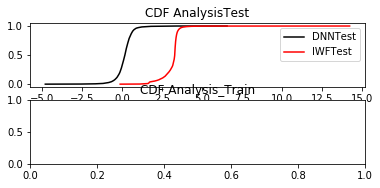

In [80]:
def CDF_Plot(sumRate1, sumRate2, label1= 'DNN', label2= 'IWF'):
    a = np.array(sumRate1) # your array of numbers
    num_bins1 = np.linspace(0, max(sumRate1), 50)
    counts1, bin_edges1 = np.histogram(a, bins='auto', normed=True)
    cdf1 = np.cumsum(counts1*np.diff(bin_edges1))

    b = np.array(sumRate2) # your array of numbers
    num_bins2 = np.linspace(0, max(sumRate2), 50)
    counts2, bin_edges2 = np.histogram(b, bins='auto', normed=True)
    cdf2 = np.cumsum(counts2*np.diff(bin_edges2))

#     plt.figure(1)
#     plt.subplot(221)
#     plt.title('CDF Analysis')
    # plt.xlim([0, 6])
    plt.xlabel('sum-rate')
    plt.plot(bin_edges1[1:], cdf1, color='black', label=label1)
    plt.plot(bin_edges2[1:],cdf2,color='red', label=label2)
    plt.legend()
    return 0
plt.figure(1)
plt.subplot(311)
plt.title('CDF AnalysisTest')
CDF_Plot(nnsumRate,IWFsumRate, 'DNNTest', 'IWFTest')
plt.subplot(312)
plt.title('CDF Analysis_Train')
CDF_Plot(nnSRTrain,IWFSRTrain, 'DNNTrain', 'IWFTrain')

plt.subplot(313)
plt.title('CDF Analysis_val')
CDF_Plot(nnSRVal,IWFSRVal, 'DNNVal', 'IWFVal')



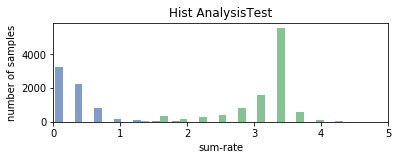

ValueError: range parameter must be finite.

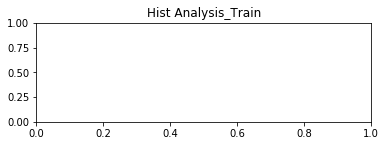

In [81]:
def histPlot(sumRate1,sumRate2, label=['DNN', 'IWF']):
#     plt.figure('%d'%K)
    plt.style.use('seaborn-deep')
    data = np.vstack([sumRate1, sumRate2]).T
    bins = np.linspace(0, max(sumRate2),50)
    plt.hist(data, bins, alpha=0.7, label=label)
#     plt.legend(loc='upper right')
    plt.xlim([0, 5])
    plt.xlabel('sum-rate')
    plt.ylabel('number of samples')
    #     plt.savefig('Histogram_%d.eps'%K, format='eps', dpi=1000)
    plt.show()
    return 0
plt.figure(2)
plt.subplot(211)
plt.title('Hist AnalysisTest')
histPlot(nnsumRate,IWFsumRate, ['DNNTest', 'IWFTest'])
plt.subplot(212)
plt.title('Hist Analysis_Train')
histPlot(nnSRTrain,IWFSRTrain, ['DNNTrain', 'IWFTrain'])



In [82]:
def performance(sumRate1,sumRate2, num):
# sumRate1, IWF; sumRate2, NN
    print('Sum-rate: IWF: %0.3f, DNN: %0.3f'%(sum(sumRate1)/num, sum(sumRate2)/num))
    print('Ratio: DNN: %0.3f%%\n' % (sum(sumRate2) / sum(sumRate1)* 100))
    return 0
performance(IWFsumRate, nnsumRate, 10000)
performance(IWFSRTrain, nnSRTrain, 10000)

Sum-rate: IWF: 3.114, DNN: 0.134
Ratio: DNN: 4.315%

Sum-rate: IWF: nan, DNN: 1.924
Ratio: DNN: nan%



0